In [38]:
# Welcome to your new notebook
# Type here in the cell editor to add code!
import warnings
import requests
import io
import re
import string
import pandas as pd
import numpy as np
import uuid
import os
import json

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.cluster import KMeans

from pyspark.sql.functions import col, pandas_udf, PandasUDFType
from pyspark.sql import functions as F
from pyspark.sql.functions import udf

import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient

warnings.simplefilter("ignore", DeprecationWarning)
%matplotlib inline

StatementMeta(, b1426e30-1746-414c-ba8a-08c4e2c8b5c5, 40, Finished, Available, Finished)

In [39]:
pip install spacy


StatementMeta(, b1426e30-1746-414c-ba8a-08c4e2c8b5c5, 41, Finished, Available, Finished)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 43.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.9/156.9 kB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.4/922.4 kB 170.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.0/493.0 kB 130.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.0/182.0 kB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 107.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 104.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 174.4 MB/s eta 0:00:00
Note

In [40]:
import spacy

StatementMeta(, b1426e30-1746-414c-ba8a-08c4e2c8b5c5, 42, Finished, Available, Finished)

In [42]:
!pip install PyPDF2


StatementMeta(, b1426e30-1746-414c-ba8a-08c4e2c8b5c5, 44, Finished, Available, Finished)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.6 MB/s eta 0:00:00a 0:00:01


In [43]:
import PyPDF2

StatementMeta(, b1426e30-1746-414c-ba8a-08c4e2c8b5c5, 45, Finished, Available, Finished)

In [44]:
from spacy import displacy


StatementMeta(, b1426e30-1746-414c-ba8a-08c4e2c8b5c5, 46, Finished, Available, Finished)

In [47]:
# Drag and drop
esg_urls_pd = spark.sql("SELECT * FROM lakehouse1.esgdelta LIMIT 1000").toPandas()
display(esg_urls_pd)

StatementMeta(, b1426e30-1746-414c-ba8a-08c4e2c8b5c5, 49, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, c6bcba84-8b48-483b-9239-6ed4c581fd89)

In [48]:
import io
import requests
import PyPDF2
import pandas as pd
 
# Define a function to extract content from a PDF url
def extract_content(url):
    """
    A function that, given a URL, downloads PDF text content,
    parses PDF, and returns plain text version.
    """
    try:
        # Retrieve PDF binary stream
        response = requests.get(url)
        open_pdf_file = io.BytesIO(response.content)
        pdf = PyPDF2.PdfReader(open_pdf_file)
        # Access PDF content
        text = [page.extract_text() for page in pdf.pages]
        # Return concatenated content
        return "\n".join(text)
    except Exception as e:
        # Handling exceptions and logging if necessary
        # print(f"Error processing {url}: {e}")
        return ""
 
# Apply the extract_content function to each row in the DataFrame
esg_urls_pd['content'] = esg_urls_pd['url'].apply(extract_content)
 
# Filter rows with non-empty content
esg_articles = esg_urls_pd[esg_urls_pd['content'].str.len() > 0]
display(esg_articles)

StatementMeta(, b1426e30-1746-414c-ba8a-08c4e2c8b5c5, 50, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 9976d244-b89f-40b2-adb6-4a335afd6f18)

In [49]:
# removing all ascii characters 
def remove_non_ascii(text):
  printable = set(string.printable)
  return ''.join(filter(lambda x: x in printable, text))

def not_header(line):
  # as we're consolidating broken lines into paragraphs, we want to make sure not to include headers
  return not line.isupper()

def extract_statements(nlp, text):
  """
  Extracting ESG statements from raw text by removing junk, URLs, etc.
  We group consecutive lines into paragraphs and use spacy to parse sentences.
  """
  
  # remove non ASCII characters
  text = remove_non_ascii(text)
  
  lines = []
  prev = ""
  for line in text.split('\n'):
    # aggregate consecutive lines where text may be broken down
    # only if next line starts with a space or previous does not end with dot.
    if(line.startswith(' ') or not prev.endswith('.')):
        prev = prev + ' ' + line
    else:
        # new paragraph
        lines.append(prev)
        prev = line
        
  # don't forget left-over paragraph
  lines.append(prev)

  # clean paragraphs from extra space, unwanted characters, urls, etc.
  # best effort clean up, consider a more versatile cleaner
  sentences = []
  for line in lines:
    
      # removing header number
      line = re.sub(r'^\s?\d+(.*)$', r'\1', line)
      # removing trailing spaces
      line = line.strip()
      # words may be split between lines, ensure we link them back together
      line = re.sub('\s?-\s?', '-', line)
      # remove space prior to punctuation
      line = re.sub(r'\s?([,:;\.])', r'\1', line)
      # ESG contains a lot of figures that are not relevant to grammatical structure
      line = re.sub(r'\d{5,}', r' ', line)
      # remove mentions of URLs
      line = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', r' ', line)
      # remove multiple spaces
      line = re.sub('\s+', ' ', line)
      
      # split paragraphs into well defined sentences using spacy
      for part in list(nlp(line).sents):
        sentences.append(str(part).strip())

  return sentences

# Function to extract statements using spaCy
def extract_statements(nlp, text):
    doc = nlp(text)
    # You can customize this function to extract relevant statements
    # Here we are simply returning sentences as an example
    return [sent.text for sent in doc.sents]

# # Initialize the spaCy model once
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm", disable=['ner'])

# Initialize result lists
companies = []
statements = []

# Loop through each content and apply the extract_statements function
for index, row in esg_articles.iterrows():
    content = row['content']
    company = row['company']
    
    extracted_statements = extract_statements(nlp, content)
    
    # Filter statements longer than 100 characters
    for statement in extracted_statements:
        if len(statement) > 100:
            companies.append(company)
            statements.append(statement)

# Create a DataFrame from the results
esg_statements = pd.DataFrame({
    "company": companies,
    "statement": statements
})

# Display results
print(esg_statements)

StatementMeta(, b1426e30-1746-414c-ba8a-08c4e2c8b5c5, 51, Finished, Available, Finished)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 122.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
                 company                                          statement
0               barclays  Barclays PLC Environmental Social Governance R...
1               barclays  Barclays is a British universal bank\nOur Purp...
2               barclays  For over 325 years we have funded progress, an...
3               barclays  FOR OUR CUSTOMERS AND CLIENTS\nWe will help th...
4               barclays  FOR OUR COLLEAGUES \nWe will empower them to b...
...                  ...                                                ...
8545  standard chartered  This refects the Group’s 

In [50]:
#tokenizing sentences using a custom function
# splitting each sentence into word by word vectors. 
def tokenize(sentence):
  gen = gensim.utils.simple_preprocess(sentence, deacc=True)
  return ' '.join(gen)

#lemmatizing generated tokens to reduce them to root words,
#Uses the above function
def lemmatize(nlp, text):
  
  # parse sentence using spacy
  doc = nlp(text) 
  
  # convert words into their simplest form (singular, present form, etc.)
  lemma = []
  for token in doc:
      if (token.lemma_ not in ['-PRON-']):
          lemma.append(token.lemma_)
          
  return tokenize(' '.join(lemma))

def lemmatize(nlp, text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

# Load the spaCy model once
# spacy.cli.download("en_core_web_sm")
# nlp = spacy.load("en_core_web_sm", disable=['ner'])
esg_lemma = esg_statements
# Apply lemmatization to the DataFrame (getting base of the word)
esg_lemma['lemma'] = esg_statements['statement'].apply(lambda x: lemmatize(nlp, x))

# Display the results
display(esg_lemma)

StatementMeta(, b1426e30-1746-414c-ba8a-08c4e2c8b5c5, 52, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, d9b05e4b-7d85-48fa-a9ad-055f153cbf40)

In [52]:
esg = esg_statements[['company', 'statement', 'lemma']]

StatementMeta(, b1426e30-1746-414c-ba8a-08c4e2c8b5c5, 54, Finished, Available, Finished)

StatementMeta(, b1426e30-1746-414c-ba8a-08c4e2c8b5c5, 55, Finished, Available, Finished)

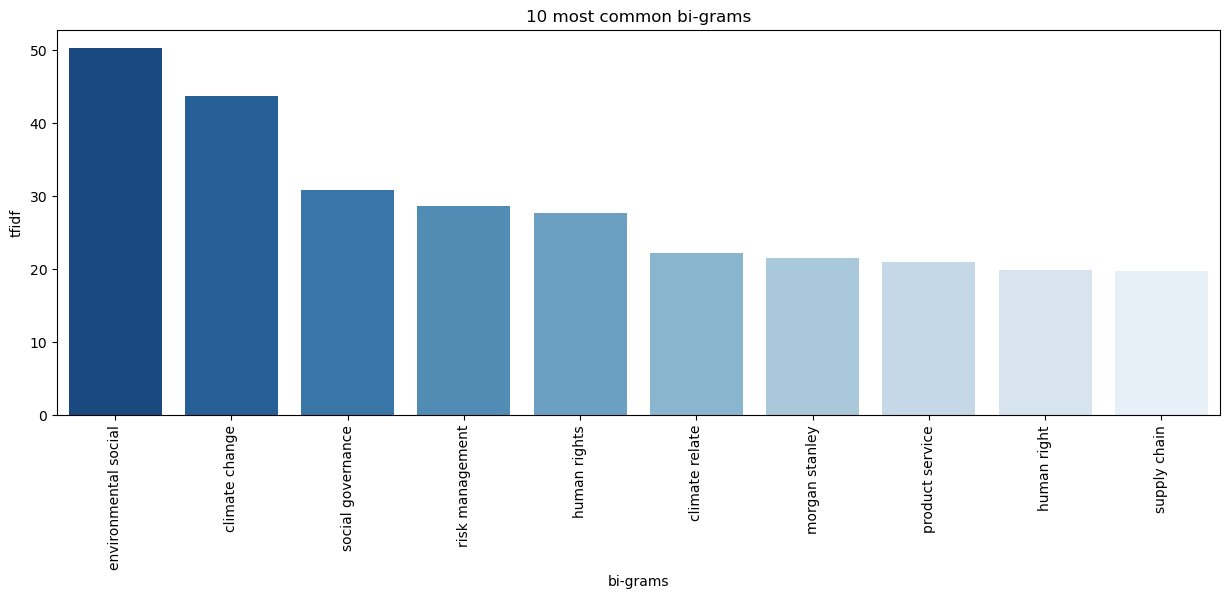

In [53]:
# Define stop words 
# NLP model to extract most common themes and areas of interest inside of ESG reports. 
fsi_stop_words = [
  'plc', 'group', 'target',
  'track', 'capital', 'holding',
  'report', 'annualreport',
  'esg', 'bank', 'report',
  'annualreport', 'long', 'make'
]
stop_words = text.ENGLISH_STOP_WORDS.union(fsi_stop_words)
stop_words = frozenset(stop_words)  # Example, replace with actual stop words

# Ensure stop words are in a list format
stop_words = list(stop_words)

# Run bi-gram TF-IDF frequencies
bigram_tf_idf_vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(2,2), min_df=1, use_idf=True)
bigram_tf_idf = bigram_tf_idf_vectorizer.fit_transform(esg['lemma'])

# Extract bi-grams names
words = bigram_tf_idf_vectorizer.get_feature_names_out()

# Extract top 10 ngrams
total_counts = np.zeros(len(words))
for t in bigram_tf_idf:
    total_counts += t.toarray()[0]

count_dict = zip(words, total_counts)
count_dict = sorted(count_dict, key=lambda x: x[1], reverse=True)[:10]
words = [w[0] for w in count_dict]
counts = [w[1] for w in count_dict]
x_pos = np.arange(len(words))

# Plot top 10 ngrams
plt.figure(figsize=(15, 5))
plt.title('10 most common bi-grams')
sns.barplot(x=x_pos, y=counts, palette='Blues_r')
plt.xticks(x_pos, words, rotation=90)
plt.xlabel('bi-grams')
plt.ylabel('tfidf')
plt.show()



In [54]:
greenstats = spark.read.format("csv").option("header","true").load("Files/greeninitiativestatistics.csv")
# df now is a Spark DataFrame containing CSV data from "Files/greeninitiativestatistics.csv".
display(greenstats)
greenstats_df = greenstats.toPandas()

StatementMeta(, b1426e30-1746-414c-ba8a-08c4e2c8b5c5, 56, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 7256fec6-cf49-448b-bfeb-d17707b1588e)

In [55]:
greenstats_df

StatementMeta(, b1426e30-1746-414c-ba8a-08c4e2c8b5c5, 57, Finished, Available, Finished)

,company,percentage_of_green_campaigns,money_invested_in_oil_companies,_c3
0,woodgrove,15%,300,None
1,pinnacle,60%,100,None
2,Summit Wealth,90%,30,None
3,Horizon Capital,80%,20,None
4,Keystone,70%,100,None
5,Red Ridge,75%,90,None
6,Sterling Vault,60%,20,None
7,Nexus,80%,95,None
8,Ironclad,85%,65,None
9,None,None,None,None


In [56]:
greenstats_df = greenstats_df.iloc[[0,1,2,3,4,5,6,7],[0,1,2]]

StatementMeta(, b1426e30-1746-414c-ba8a-08c4e2c8b5c5, 58, Finished, Available, Finished)

In [57]:
greenstats_df['percentage_of_green_campaigns'] = greenstats_df['percentage_of_green_campaigns'].str.rstrip('%').astype('int')


StatementMeta(, b1426e30-1746-414c-ba8a-08c4e2c8b5c5, 59, Finished, Available, Finished)

StatementMeta(, b1426e30-1746-414c-ba8a-08c4e2c8b5c5, 60, Finished, Available, Finished)

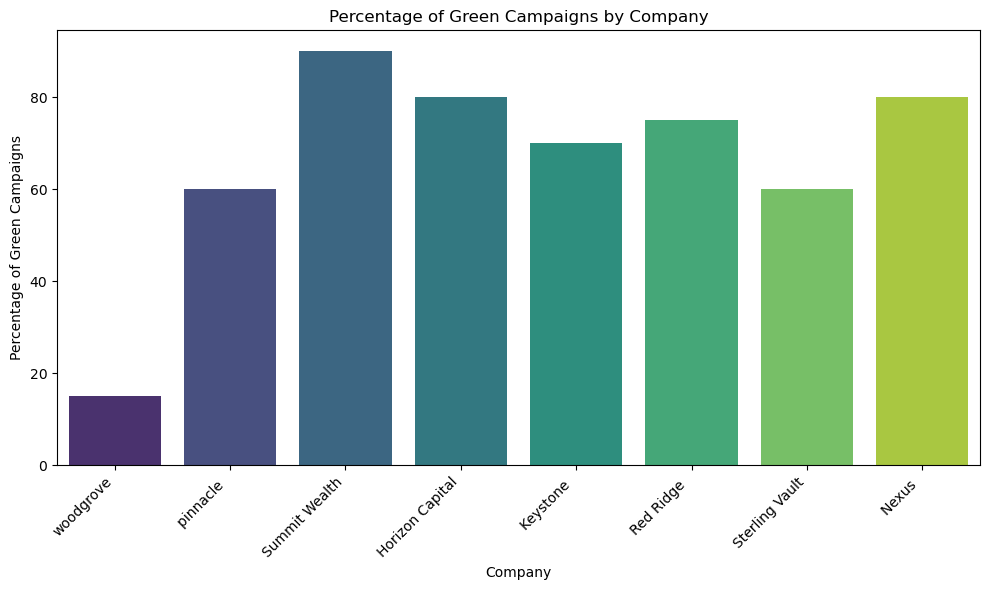

In [58]:

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='company', y='percentage_of_green_campaigns', data=greenstats_df, palette='viridis')

plt.title('Percentage of Green Campaigns by Company')
plt.xlabel('Company')
plt.ylabel('Percentage of Green Campaigns')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Show the plot
plt.show()